# Testing InceptionV3 network (variation 14) Fine-tuning

Based on variant 13:

`optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)`

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

# custom tools
import sys
sys.path.insert(0, "../")

from custom.tools import time_save_model, plot_metrics

Using TensorFlow backend.


### BASIC  IMAGE, AND BATCH SETUP

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')

SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 32

### Settings for fast checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_v2_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
# NB_CLASSES = 6
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [3]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=INPUT_SHAPE
)

In [6]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': NB_CLASSES,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dense(**pred_layer_config))

WEIGHT_PATH = os.path.join(SAVE_DIR, 'InceptionV3_13_10_20.h5')
model.load_weights(WEIGHT_PATH)

In [7]:
conv_base.trainable = True
for layer in conv_base.layers:
    layer.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights before freezing the conv base: 2


In [8]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name in [
        'conv2d_86', 'batch_normalization_86',
        'conv2d_88', 'batch_normalization_88',
        'conv2d_89', 'batch_normalization_89',
        'conv2d_92', 'batch_normalization_92',
        'conv2d_93', 'batch_normalization_93',
        'conv2d_94', 'batch_normalization_94'
    ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print('This is the number of trainable weights after '
      'after limited freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after after limited freezing the conv base: 14


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 3,221,700
Non-trainable params: 18,982,688
_________________________________________________________________


In [10]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=7)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=13)

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


Define custom metrics to measure

In [12]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [13]:
from keras import optimizers

optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc, top_5_acc])

In [16]:
EPOCHS = 10
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/10
354/354 [==============================] - 286s 808ms/step - loss: 1.0114 - categorical_accuracy: 0.7143 - top_3_acc: 0.8893 - top_5_acc: 0.9325 - val_loss: 2.0293 - val_categorical_accuracy: 0.4925 - val_top_3_acc: 0.7113 - val_top_5_acc: 0.7863
Epoch 2/10
354/354 [==============================] - 287s 811ms/step - loss: 1.0372 - categorical_accuracy: 0.7159 - top_3_acc: 0.8829 - top_5_acc: 0.9297 - val_loss: 1.8981 - val_categorical_accuracy: 0.5242 - val_top_3_acc: 0.7346 - val_top_5_acc: 0.8063
Epoch 3/10
354/354 [==============================] - 287s 811ms/step - loss: 0.9843 - categorical_accuracy: 0.7266 - top_3_acc: 0.8932 - top_5_acc: 0.9364 - val_loss: 1.9749 - val_categorical_accuracy: 0.5025 - val_top_3_acc: 0.7204 - val_top_5_acc: 0.8000
Epoch 4/10
354/354 [==============================] - 287s 809ms/step - loss: 0.9363 - categorical_accuracy: 0.7368 - top_3_acc: 0.9035 - top_5_acc: 0.9393 - val_loss: 1.9598 - val_categorical_accuracy: 0.5079 - val_top_3_acc:

In [18]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                'InceptionV3_14_10_20',
                SAVE_DIR)

traing took: 48.0 minutes


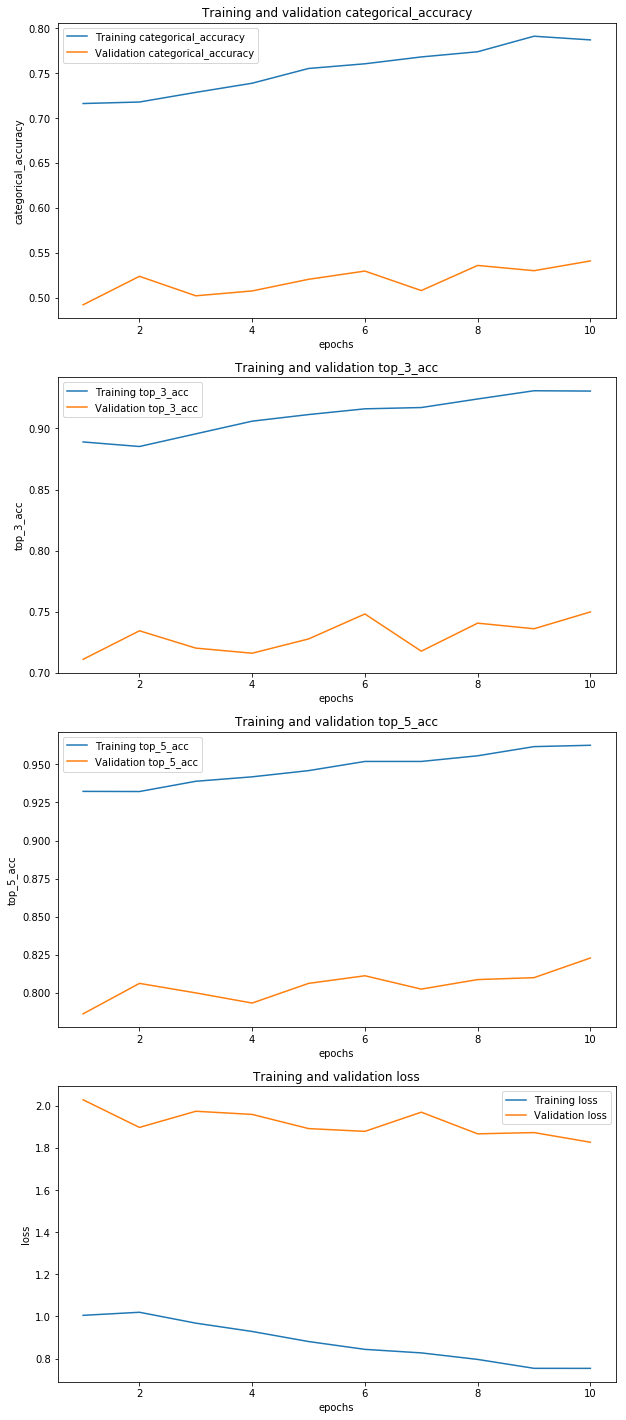

In [19]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']
show = plot_metrics(summary.history, key_list)